In [1]:
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import sys; sys.path.insert(0, "../"); from utils import *
from parametric_discovery_pinn import ParametricPINN
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR
from parametric_pde_diff import TrainSGTRidge, create_groups

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pickle_load("../parametric_pde_data/parametric_burgers.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]

Exact = data['u']
X, T = np.meshgrid(x, t)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 20000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

u_xx_true = 0.1*np.ones(time_dims)
uu_x_true = -1*(1+0.25*np.sin(t))

Loaded from ../parametric_pde_data/parametric_burgers.pkl


In [3]:
pinn = ParametricPINN(scale=False, lb=lb, ub=ub)
pinn.load_state_dict(torch.load("./saved_path_inverse_parametric_burgers/tmp.pth"))

<All keys matched successfully>

In [4]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    losses = pinn.loss(*dimension_slicing(X_train), u_train)
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

In [5]:
def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = sum(pinn.loss(*dimension_slicing(X_train), u_train))
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

In [6]:
grads_dict = pinn.gradients_dict(*dimension_slicing(X_star))

feature_names = list(grads_dict.keys())
u_t_index = feature_names.index('u_t')

referenced_derivatives = np.hstack([t.detach().numpy() for t in list(grads_dict.values())])
u_t = referenced_derivatives[:, u_t_index:u_t_index+1]

referenced_derivatives = np.delete(referenced_derivatives, u_t_index, 1)
del feature_names[u_t_index]

print(feature_names)

['u', 'u_x', 'u_xx']


In [7]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Theta = poly.fit_transform(referenced_derivatives)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

In [8]:
Theta_grouped, Ut_grouped = create_groups(Theta, u_t, spatial_dims, time_dims)

The outputs can be used by the TrainSGTRidge function.


In [9]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_burgers/../parametric_pde_diff.py:602: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_burgers/../parametric_pde_diff.py:572: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


In [10]:
poly_feature_names

['u', 'u_x', 'u_xx', 'u*u_x', 'u*u_xx', 'u_x*u_xx']

2 -> u_xx
3 -> u*u_x
MSE:  0.0008046205037859196


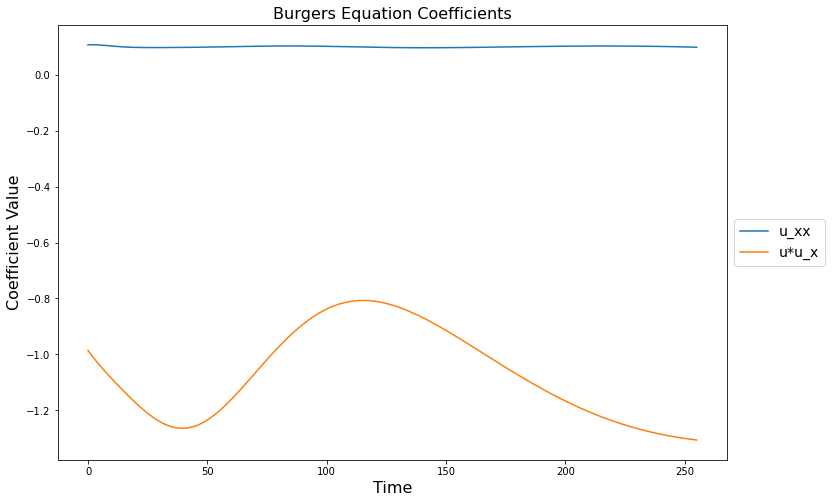

In [11]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, '->', poly_feature_names[j])
        plot(xi[j,:], label = poly_feature_names[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

i_uu_x = [i for i in range(len(poly_feature_names)) if poly_feature_names[i] == 'u*u_x'][0]
i_u_xx = [i for i in range(len(poly_feature_names)) if poly_feature_names[i] == 'u_xx'][0]
xi_true = np.zeros(xi.shape)
xi_true[i_uu_x] = uu_x_true
xi_true[i_u_xx] = u_xx_true
mse_clean_sgtr = np.linalg.norm(xi-xi_true)**2/(time_dims*16)

print('MSE: ', mse_clean_sgtr)

In [12]:
# Using PySR to discovry right away is not good (works sometimes, sometimes not!)
# if the derivatives are calculated using a neural network.
equations = pysr(
    t, xi[3, :],
    populations=50, npop=1500, niterations=5,
    binary_operators=["+", "*"],
    unary_operators=["sin", "cos"],
)

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmpjaz7q2v9/runfile.jl
Activating environment on workers.
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 1.480e+03
Head worker occupation: 4.9%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.662e-02  -0.000e+00  -1.0715084
5           2.552e-02  1.050e-02  (-1.0144207 + (-0.011417637 * x0))


In [13]:
best(equations)

-0.19016004*sin(x0) - 1.0368807

#### Training

In [6]:
# ใส่เพิ่มทีหลังได้
# optimizer = MADGRAD(pinn.parameters(), lr=1e-3, momentum=0.9)
# for i in range(150):
#     pinn.train()
#     optimizer.step(pcgrad_closure)
#     if i%10==0:
#         loss = pcgrad_closure(return_list=True)
#         print(loss)
        
f_opt = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=300, history_size=300)
for i in range(50):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())
        
# −1.0383017−0.17971173*np.sin(t) will be detected.

6.464694160968065e-05
2.566914872659254e-06
2.5650622319517424e-06
2.564962414908223e-06
2.564962414908223e-06


In [14]:
pinn.loss(*dimension_slicing(X_star), u_star)

(tensor(2.0434e-06, grad_fn=<MseLossBackward>),
 tensor(5.4735e-07, grad_fn=<MseLossBackward>))

In [15]:
u_preds, learned_func = pinn(*dimension_slicing(X_star))
learned_func1 = learned_func[:, 0:1].reshape(X.shape).mean(axis=1).detach().numpy()
learned_func2 = learned_func[:, 1:2].reshape(X.shape).mean(axis=1).detach().numpy()

In [16]:
print(np.mean((learned_func1-uu_x_true)**2))
print(np.mean((learned_func2-u_xx_true)**2))

0.016162229544351373
5.448478063125935e-06


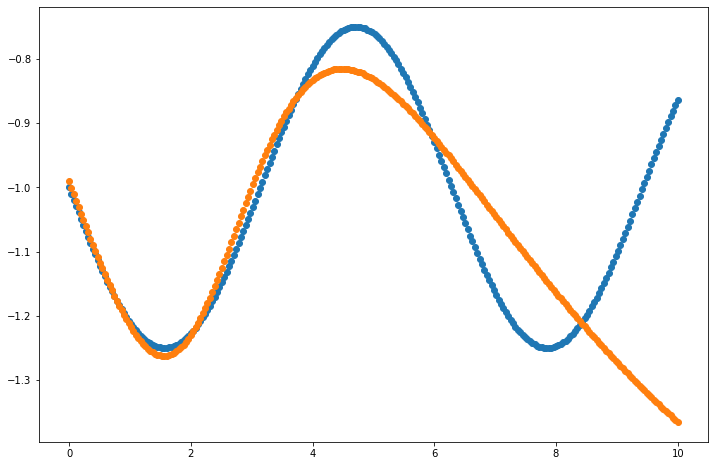

In [17]:
# You can chk from this graph that learned_func1 depend on x or t 
# Working when using .mean(axis=0) -> depending on x
# Working when using .mean(axis=1) -> depending on t
plt.scatter(t, uu_x_true)
plt.scatter(t, learned_func1)
plt.show()

In [20]:
equations = pysr(
    t, learned_func1,
    populations=50, npop=1500, niterations=5,
    binary_operators=["+", "*"],
    unary_operators=["sin", "cos"],
)

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmpjbsh1evt/runfile.jl
Activating environment on workers.
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 9.630e+02
Head worker occupation: 3.4%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.762e-02  -0.000e+00  -1.0710335
5           2.643e-02  1.106e-02  (-1.0113833 + (-0.01192953 * x0))
6

In [21]:
best(equations)

-0.1797151*sin(x0) - 1.0383075

In [ ]:
# To discover using TrainSGTRidge

# Compute Theta -> Candi features and estimated u_t
# Create the groups
# Train TrainSGTRidge
# Look for np.linalg.norm(xi[j,:]) > 10**-10
# Apply PySR on the results